In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scib
import anndata 

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


import seaborn as sns

import tissue.api as tissue

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
# user = "david.fischer"
# user = "ina"
user = "mayar.ali"

if user == "david.fischer":
    base_path_gcn = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
    base_path_mi = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
    base_path_reg = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
elif user == "ina":
    base_path_gcn = '../../results/GCN/basel_zurich/'
    base_path_reg = '../../results/REG/basel_zurich/'
    
elif user == "mayar.ali":
    base_path_gcn = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"
    base_path_mi = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"
    base_path_reg = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"


# Overall

In [4]:
dir_figures="/storage/groups/ml01/workspace/mayar.ali/tissue/figures/basel_zurich/"

In [65]:
def get_cells_features(layer_name, interpreter):
    # get features of cells

    if layer_name == 'input':
        h = [interpreter.h[image_key] for image_key in interpreter.img_keys_test]
    else:
        acts = interpreter._get_node_embeddings(
        idx=interpreter.img_keys_test,
        layers=[layer_name]
        )
        h = acts[layer_name]
        
    cells = np.concatenate(h)
    cells = cells[:, cells.std(axis=0) > 0]
    cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)

    images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

    adata_cells = anndata.AnnData(
        cells,
        obs=pd.DataFrame({
            "images": images,
        })
    )

    adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])
    return adata_cells

In [66]:
def get_intergation_metrics(adata_cells, model, cvx):
    
    metrics = [model, cvx]
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

    print(f"{layer_name=}")
    image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
    print(f'Images training score: {image_score}')
    metrics.append(image_score)



    from sklearn.metrics import explained_variance_score, r2_score

    explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                               logreg.predict(adata_cells.X))
    print(f'Variance explained - images : {explained_variance_score_images}')
    metrics.append(explained_variance_score_images)

    r2_score_images = r2_score(adata_cells.obs["images_label"], 
                               logreg.predict(adata_cells.X), 
                               multioutput='uniform_average')
    print(f'R2 score - images: {r2_score_images}')
    metrics.append(r2_score_images)
    
    n_neighbors=50
    sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
    sc.tl.pca(adata_cells)

    label_key="images"
    graph_conn = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
    metrics.append(graph_conn)
    print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_conn}')

    label_key="images"
    ilisi = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
    metrics.append(ilisi)
    print(f'ilisi graph  metric {layer_name} layer - {label_key} = {ilisi}')

    df = pd.DataFrame(columns=["model", "cv", "prediction_score", "variance_explained", 
                               "r2_score", "graph_connectivity", "ilisi"])
    df.loc[0] = metrics
    return df

#### GCN SS

In [63]:
container_gcnss = tissue.fits.GridSearchContainer(
    source_path={
        "2205191027_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191027_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt_best_model",
        
    ]
)
container_gcnss.load_gs()

loaded 2205191027_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt_best_model: 1 runs with 3-fold cross validation


In [64]:
gs_id, model_id, cv = container_gcnss.get_best_model_id(partition_select='val')
container_gcnss.get_info(gs_id = gs_id, model_id=model_id)
print(model_id)
container_gcnss.runparams[gs_id][model_id]

gcnss_none_basel_zurich_gradeadam_lr1_dr1_drp1_l21_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc2_ew1_nh1_ssmultitask


{'model_id': 'gcnss_none_basel_zurich_gradeadam_lr1_dr1_drp1_l21_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc2_ew1_nh1_ssmultitask',
 'model_class': 'gcnss',
 'gs_id': '2205191027_gcnss_none_grade_standard_basel_zurich_radius_mt_best_model',
 'data_set': 'basel_zurich',
 'max_dist': 20,
 'target_label': 'grade',
 'graph_label_selection': ['DFSmonth',
  'ERStatus',
  'HER2Status',
  'PRStatus',
  'grade',
  'tumor_size'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.05,
 'depth_feature_embedding': 0,
 'depth': 2,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 0.0,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 10,
 'entropy_weight

In [67]:
df_metrics = pd.DataFrame(columns=["model", "cv", "prediction_score", 
                                   "variance_explained", "r2_score", "graph_connectivity", 
                                   "ilisi"])
df_metrics

Empty DataFrame
Columns: [model, cv, prediction_score, variance_explained, r2_score, graph_connectivity, ilisi]
Index: []

In [68]:
models = {
    'input': 'input',
    'Layer_gcn_1': 'GCNSS'
}
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCNSS")
    interpreter.load_model()
    #     source_path,
    #     gs_ids,
    #     partition_select='test',
    #     load_labels=['grade']
    # )
    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    interpreter.get_data_again(
        data_path=data_path,
    #     buffered_data_path=buffered_data_path,
    )

    for layer_name in ['input', 'Layer_gcn_1']:
        print(f"{layer_name=}")
        adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
        df = get_intergation_metrics(adata_cells, models[layer_name], cvx)
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    

cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.8114738544669239
Variance explained - images : 0.8655326844605429
R2 score - images: 0.8653521496849903
graph connectivity metric input layer - images = 0.9687026138811815
/tmp/lisi_mma2kqmi/input.mtx /tmp/lisi_mma2kqmi/
ilisi graph  metric input layer - images = 0.02763759462409147
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f26a81f6520>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.45152662443864133
Variance explained - images : 0.35158955324377983
R2 score - images: 0.2774980547651187
graph connectivity metric Layer_gcn_1 layer - images = 0.8852766533479506
/tmp/lisi_ycrw3m75/input.mtx /tmp/lisi_ycrw3m75/
ilisi graph  metric Layer_gcn_1 layer - images = 0.041435015891878646
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.8114738544669239
Variance explained - images : 0.8655326844605429
R2 score - images: 0.8653521496849903
graph connectivity metric input layer - images = 0.9687026138811815
/tmp/lisi_ta6ocwek/input.mtx /tmp/lisi_ta6ocwek/
ilisi graph  metric input layer - images = 0.02763759462409147
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f26a07f2460>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.4815711716921631
Variance explained - images : 0.4868329376469709
R2 score - images: 0.4657561155289036
graph connectivity metric Layer_gcn_1 layer - images = 0.7953920835371787
/tmp/lisi_k_9ltdaj/input.mtx /tmp/lisi_k_9ltdaj/
ilisi graph  metric Layer_gcn_1 layer - images = 0.06142336446542516
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.8114738544669239
Variance explained - images : 0.8655326844605429
R2 score - images: 0.8653521496849903
graph connectivity metric input layer - images = 0.9687026138811815
/tmp/lisi__qet2d0o/input.mtx /tmp/lisi__qet2d0o/
ilisi graph  metric input layer - images = 0.02763759462409147
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f268e4594c0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.4569662687834895
Variance explained - images : 0.40884089088182285
R2 score - images: 0.3629290561533002
graph connectivity metric Layer_gcn_1 layer - images = 0.8740828216188745
/tmp/lisi_ig2i0ki_/input.mtx /tmp/lisi_ig2i0ki_/
ilisi graph  metric Layer_gcn_1 layer - images = 0.03961483775955447


In [69]:
df_metrics

model   cv  prediction_score  variance_explained  r2_score  \
0  input  cv0          0.811474            0.865533  0.865352   
1  GCNSS  cv0          0.451527            0.351590  0.277498   
2  input  cv1          0.811474            0.865533  0.865352   
3  GCNSS  cv1          0.481571            0.486833  0.465756   
4  input  cv2          0.811474            0.865533  0.865352   
5  GCNSS  cv2          0.456966            0.408841  0.362929   

   graph_connectivity     ilisi  
0            0.968703  0.027638  
1            0.885277  0.041435  
2            0.968703  0.027638  
3            0.795392  0.061423  
4            0.968703  0.027638  
5            0.874083  0.039615

In [7]:
interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="GCNSS")
interpreter.load_model()

data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/basel_zurich/"
buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/basel_zurich/"
interpreter.get_data_again(
    data_path=data_path,
)

2022-06-02 09:41:34.183494: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 09:41:34.183561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: supergpu05.scidom.de
2022-06-02 09:41:34.183569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: supergpu05.scidom.de
2022-06-02 09:41:34.183674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-06-02 09:41:34.183713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-06-02 09:41:34.183719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2022-06-02 09:41:34.184042: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.



In [ ]:
interpreter.plot_umap_graphs(
    label='grade',
    data_key='bz',
#     save='fig3c_refactored'
)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f45aab48a60>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f456682a100>


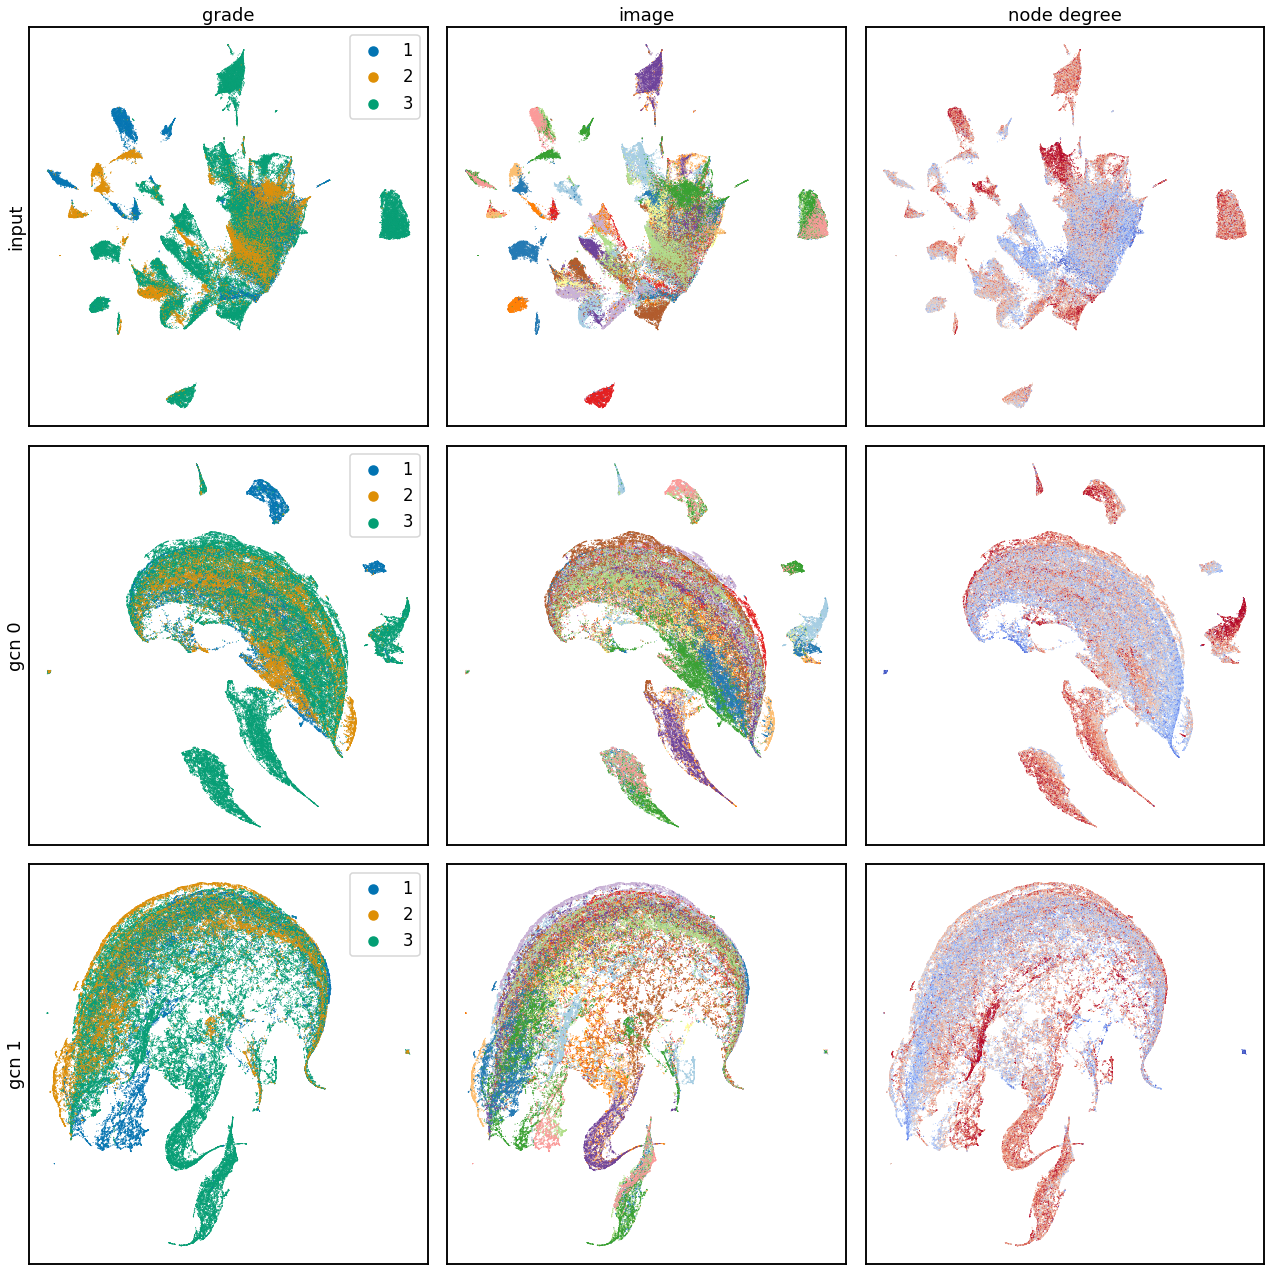

In [9]:
interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_gcn_0',
        'Layer_gcn_1',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='bz',
    save=dir_figures+"supp_gcnss_std_node_emb_refactored", 
)

In [8]:
# get features of cells

layer_name = 'input'
h = [interpreter.h[image_key] for image_key in interpreter.img_keys_test]

cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)

images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
predict_score_images_cells = []

varian_explained_images_cells = []
r2_images_cells = []
r2_linreg_images_cells = []

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.8114738544669239
Variance explained - images : 0.8655326844605429
R2 score - images: 0.8653521496849903
R2 score linreg - images: 0.8695871895475824


In [11]:
graph_connectivity_cells_images = []
ilisi_cells_images = []

In [12]:
n_neighbors=50
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric input layer - images = 0.9687026138811815
/tmp/lisi_253yutmv/input.mtx /tmp/lisi_253yutmv/
ilisi graph  metric input layer - images = 0.02763759462409147


In [13]:
layer_name = 'Layer_gcn_1'
acts = interpreter._get_node_embeddings(
        idx=interpreter.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f271d4d1340>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.45105675482745844
Variance explained - images : 0.3892849213329105
R2 score - images: 0.34107365251941135
R2 score linreg - images: 0.4560302324722164


In [14]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - images = 0.8825726484200458
/tmp/lisi_8h39o0uv/input.mtx /tmp/lisi_8h39o0uv/
ilisi graph  metric Layer_gcn_1 layer - images = 0.03928006990790149


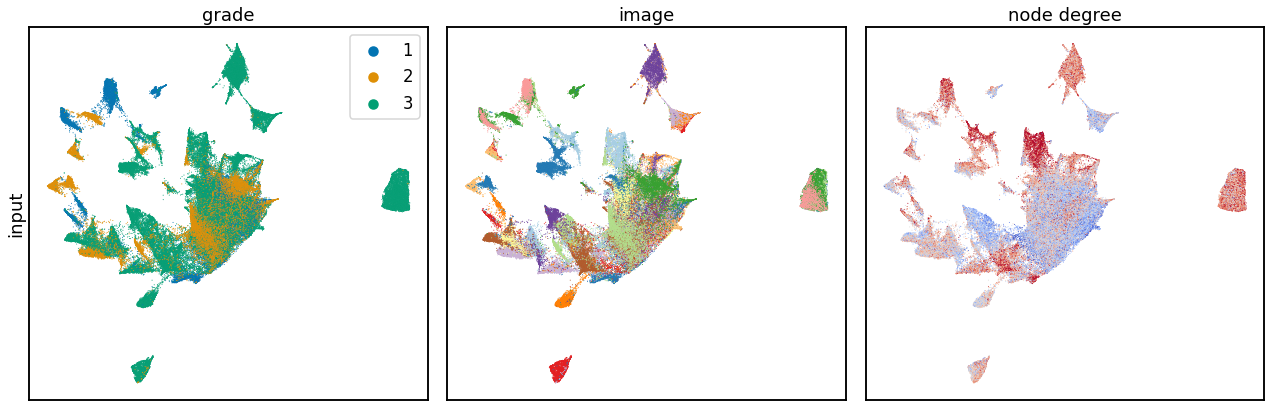

In [15]:
n_neighbors=50
layer_name = 'input'
umap_emb, hue = interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='bz',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [16]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
predict_score_images = []
predict_score_grade = []

In [18]:
varian_explained_images = []
r2_images = []
r2_linreg_images = []

In [19]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.26755459975241486
Grade training score: 0.6337004942666872
Variance explained - images : 0.41725540947546924
R2 score - images: 0.3538219723245517
R2 score linreg - images: 0.46609453419130703


In [21]:
graph_conn_grade = []
ilsi_graph_grade = []

graph_conn_images = []
ilsi_graph_images = []

In [22]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric input layer - grade = 0.5892919935582835
graph connectivity metric input layer - images = 0.5585503059111916
/tmp/lisi_085284cw/input.mtx /tmp/lisi_085284cw/
ilisi graph metric input layer - grade = 0.0613035989436751
/tmp/lisi_gp4_rq9r/input.mtx /tmp/lisi_gp4_rq9r/
ilisi graph  metric input layer - images = 0.0308005256679866


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2689307700>


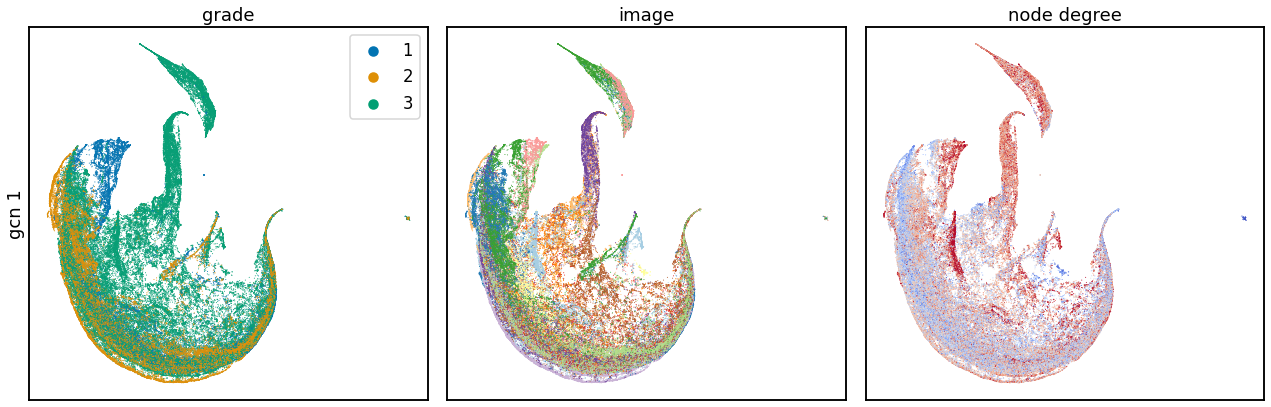

In [23]:
n_neighbors=50
layer_name = 'Layer_gcn_1'
umap_emb, hue = interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='bz',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [24]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_gcn_1'
Images training score: 0.1714753002195737
Grade training score: 0.6201194553126892
Variance explained - images : 0.12034563430805656
R2 score - images: -0.12103590266165809
R2 score linreg - images: 0.2548201805387723


In [28]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - grade = 0.8296275503691394
graph connectivity metric Layer_gcn_1 layer - images = 0.45973895237572
/tmp/lisi_sn8s4t6n/input.mtx /tmp/lisi_sn8s4t6n/
8841 has not enough neighbors.
8844 has not enough neighbors.
8860 has not enough neighbors.
8872 has not enough neighbors.
8875 has not enough neighbors.
8885 has not enough neighbors.
8886 has not enough neighbors.
8894 has not enough neighbors.
8913 has not enough neighbors.
8918 has not enough neighbors.
8919 has not enough neighbors.
8920 has not enough neighbors.
8929 has not enough neighbors.
ilisi graph metric Layer_gcn_1 layer - grade = 0.36039239985703353
/tmp/lisi_md070236/input.mtx /tmp/lisi_md070236/
8841 has not enough neighbors.
8844 has not enough neighbors.
8860 has not enough neighbors.
8872 has not enough neighbors.
8875 has not enough neighbors.
8885 has not enough neighbors.
8886 has not enough neighbors.
8894 has not enough neighbors.
8913 has not enough neighbors.
8918 has

#### GCN

In [70]:
container_gcn = tissue.fits.GridSearchContainer(
    source_path={
        "2205191032_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model": base_path_gcn,
        "2205310906_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191032_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model",
        "2205310906_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model"
        
    ]
)
container_gcn.load_gs()

loaded 2205191032_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model: 1 runs with 3-fold cross validation
loaded 2205310906_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model: 1 runs with 3-fold cross validation


In [71]:
gs_id, model_id, cv = container_gcn.get_best_model_id(partition_select='val')
container_gcn.get_info(gs_id = gs_id, model_id=model_id)
print(model_id)
container_gcn.runparams[gs_id][model_id]

gcn_none_basel_zurich_gradeadam_lr2_dr1_drp1_l21_de3_wi4_lw4_lt1_bs2_md3_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc3_ew1_nh1_ssnone


{'model_id': 'gcn_none_basel_zurich_gradeadam_lr2_dr1_drp1_l21_de3_wi4_lw4_lt1_bs2_md3_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc3_ew1_nh1_ssnone',
 'model_class': 'gcn',
 'gs_id': '2205310906_gcn_none_grade_standard_basel_zurich_radius_best_model',
 'data_set': 'basel_zurich',
 'max_dist': 50,
 'target_label': 'grade',
 'graph_label_selection': ['DFSmonth',
  'ERStatus',
  'HER2Status',
  'PRStatus',
  'grade',
  'tumor_size'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.005,
 'depth_feature_embedding': 0,
 'depth': 3,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 0.0,
 'loss_weight_others': 1.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 20,
 'entropy_weight': 0.0001,
 '

In [72]:
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCN")
    interpreter.load_model()
    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    interpreter.get_data_again(
        data_path=data_path,
    )

    layer_name='Layer_gcn_1'
    print(f"{layer_name=}")
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "GCN", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)

cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_50_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f267a641a60>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.9841780444388221
Variance explained - images : 0.9881583211223842
R2 score - images: 0.9881582927183632
         Falling back to preprocessing with `sc.pp.pca` and default params.
graph connectivity metric Layer_gcn_1 layer - images = 0.9812552613206308
/tmp/lisi_xha2ujtq/input.mtx /tmp/lisi_xha2ujtq/
ilisi graph  metric Layer_gcn_1 layer - images = 0.002017339635926987
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_50_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f266535ab20>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.9884701226178966
Variance explained - images : 0.9937971464589944
R2 score - images: 0.9937966000436272
         Falling back to preprocessing with `sc.pp.pca` and default params.
graph connectivity metric Layer_gcn_1 layer - images = 0.9881820281752385
/tmp/lisi_i1pbq105/input.mtx /tmp/lisi_i1pbq105/
ilisi graph  metric Layer_gcn_1 layer - images = 0.00025219947334291693
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_50_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f26235d4dc0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.984864776947474
Variance explained - images : 0.9918958710207466
R2 score - images: 0.9918957643947145
         Falling back to preprocessing with `sc.pp.pca` and default params.
graph connectivity metric Layer_gcn_1 layer - images = 0.9821214922329761
/tmp/lisi_gk7wg66m/input.mtx /tmp/lisi_gk7wg66m/
ilisi graph  metric Layer_gcn_1 layer - images = 0.00105545574488652


In [31]:
interpreter_gcn = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="GCN")
interpreter_gcn.load_model()


data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/basel_zurich/"
buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/basel_zurich/"
interpreter_gcn.get_data_again(
    data_path=data_path,
)

/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_50_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.



/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f4548e44d00>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f44e82adac0>


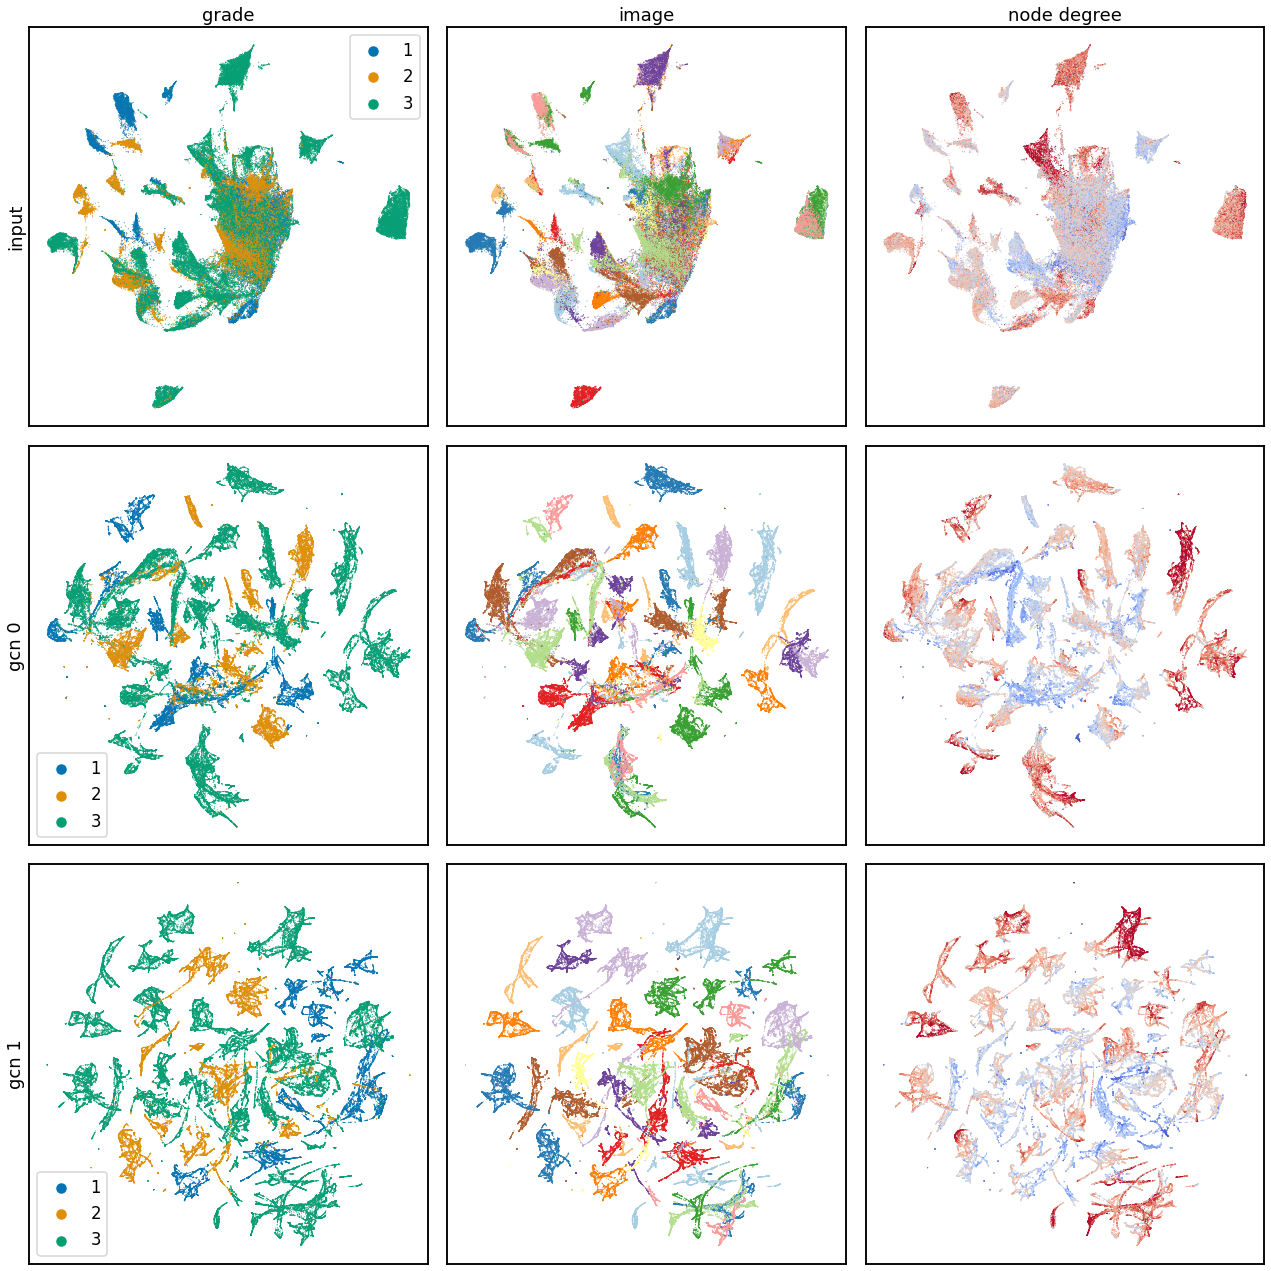

In [37]:
interpreter_gcn.plot_umap_nodes(
    interpreter_gcn.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_gcn_0',
        'Layer_gcn_1',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='bz',
    save=dir_figures+"supp_gcn_std_node_emb_refactored", 
)

In [33]:
layer_name = 'Layer_gcn_1'
acts = interpreter_gcn._get_node_embeddings(
        idx=interpreter_gcn.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter_gcn.h[id].shape[0] for id in interpreter_gcn.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f26bfa39d60>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.9841780444388221
Variance explained - images : 0.9881583211223842
R2 score - images: 0.9881582927183632
R2 score linreg - images: 0.9881983826936516


In [34]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

         Falling back to preprocessing with `sc.pp.pca` and default params.
graph connectivity metric Layer_gcn_1 layer - images = 0.9812552613206308
/tmp/lisi_x7j_rzop/input.mtx /tmp/lisi_x7j_rzop/
ilisi graph  metric Layer_gcn_1 layer - images = 0.002017339635926987


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f26d4cb3820>


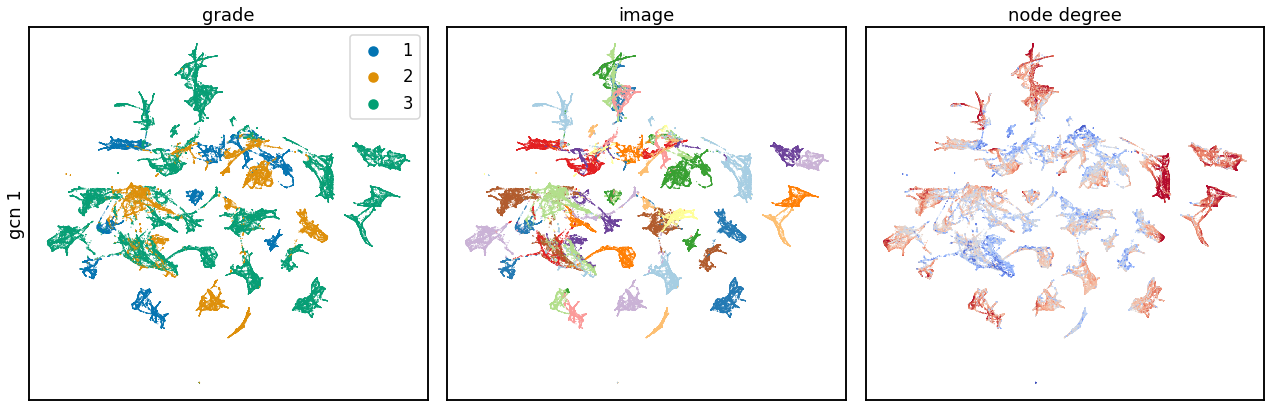

In [35]:
n_neighbors=50
layer_name = 'Layer_gcn_1'
umap_emb, hue = interpreter_gcn.plot_umap_nodes(
    interpreter_gcn.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='bz',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [36]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [37]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_gcn_1'
Images training score: 0.7120964317017412
Grade training score: 0.6201194553126892
Variance explained - images : 0.6887862808346276
R2 score - images: 0.6820358877125022
R2 score linreg - images: 0.7054042795381729


In [41]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - grade = 0.28522323475826866
graph connectivity metric Layer_gcn_1 layer - images = 0.8607885133413432
/tmp/lisi_6o6fzsoz/input.mtx /tmp/lisi_6o6fzsoz/
22597 has not enough neighbors.
22644 has not enough neighbors.
22664 has not enough neighbors.
22687 has not enough neighbors.
22728 has not enough neighbors.
22852 has not enough neighbors.
22903 has not enough neighbors.
22919 has not enough neighbors.
36687 has not enough neighbors.
70295 has not enough neighbors.
70297 has not enough neighbors.
70331 has not enough neighbors.
70372 has not enough neighbors.
70412 has not enough neighbors.
70437 has not enough neighbors.
70452 has not enough neighbors.
70467 has not enough neighbors.
70499 has not enough neighbors.
70500 has not enough neighbors.
70505 has not enough neighbors.
70506 has not enough neighbors.
70508 has not enough neighbors.
70510 has not enough neighbors.
70512 has not enough neighbors.
70514 has not enough neighbors.
705

#### MI

In [73]:
container_mi = tissue.fits.GridSearchContainer(
    source_path={
        "2205191134_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191134_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model",
        
    ]
)
container_mi.load_gs()

loaded 2205191134_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model: 1 runs with 3-fold cross validation


In [74]:
gs_id, model_id, cv = container_mi.get_best_model_id(partition_select='val')
container_mi.get_info(gs_id = gs_id, model_id=model_id)
print(model_id)
container_mi.runparams[gs_id][model_id]

mi_none_basel_zurich_gradeadam_lr1_dr1_drp1_l22_de1_wi1_lw1_lt1_bs2_md1_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc2_ew1_nh1_ssnone


{'model_id': 'mi_none_basel_zurich_gradeadam_lr1_dr1_drp1_l22_de1_wi1_lw1_lt1_bs2_md1_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc2_ew1_nh1_ssnone',
 'model_class': 'mi',
 'gs_id': '2205191134_mi_none_grade_standard_basel_zurich_radius_best_model',
 'data_set': 'basel_zurich',
 'max_dist': 10,
 'target_label': 'grade',
 'graph_label_selection': ['DFSmonth',
  'ERStatus',
  'HER2Status',
  'PRStatus',
  'grade',
  'tumor_size'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.05,
 'depth_feature_embedding': 0,
 'depth': 1,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 1e-06,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 10,
 'entropy_weight': 0.0001,
 'nu

In [75]:
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterNoGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="MI")
    interpreter.load_model()
    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    interpreter.get_data_again(
        data_path=data_path,
    )

    layer_name='Layer_dense_feature_embedding0'
    print(f"{layer_name=}")
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "MI", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)

cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_10_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.3504504423099513
Variance explained - images : 0.2288964490326194
R2 score - images: 0.14641780843178576
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.8189061544820725
/tmp/lisi_ev4zfs86/input.mtx /tmp/lisi_ev4zfs86/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.07187149128166487
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_10_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.3504504423099513
Variance explained - images : 0.2288964490326194
R2 score - images: 0.14641780843178576
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.8189061544820725
/tmp/lisi_qmy0sqxp/input.mtx /tmp/lisi_qmy0sqxp/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.07187149128166487
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_10_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.3504504423099513
Variance explained - images : 0.2288964490326194
R2 score - images: 0.14641780843178576
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.8189061544820725
/tmp/lisi_txk297wd/input.mtx /tmp/lisi_txk297wd/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.07187149128166487


In [77]:
df_metrics["1 - graph_connectivity"] = [1 - x for x in df_metrics["graph_connectivity"]]
df_metrics.to_csv(dir_figures + "df_metrics.csv")
df_metrics

model   cv  prediction_score  variance_explained  r2_score  \
0   input  cv0          0.811474            0.865533  0.865352   
1   GCNSS  cv0          0.451527            0.351590  0.277498   
2   input  cv1          0.811474            0.865533  0.865352   
3   GCNSS  cv1          0.481571            0.486833  0.465756   
4   input  cv2          0.811474            0.865533  0.865352   
5   GCNSS  cv2          0.456966            0.408841  0.362929   
6     GCN  cv0          0.984178            0.988158  0.988158   
7     GCN  cv1          0.988470            0.993797  0.993797   
8     GCN  cv2          0.984865            0.991896  0.991896   
9      MI  cv0          0.350450            0.228896  0.146418   
10     MI  cv1          0.350450            0.228896  0.146418   
11     MI  cv2          0.350450            0.228896  0.146418   

    graph_connectivity     ilisi  1 - graph_connectivity  
0             0.968703  0.027638                0.031297  
1             0.885277  0.041435                0.114723  
2             0.968703  0.027638                0.031297  
3             0.795392  0.061423                0.204608  
4             0.968703  0.027638                0.031297  
5             0.874083  0.039615                0.125917  
6             0.981255  0.002017                0.018745  
7             0.988182  0.000252                0.011818  
8             0.982121  0.001055                0.017879  
9             0.818906  0.071871                0.181094  
10            0.818906  0.071871                0.181094  
11            0.818906  0.071871                0.181094

In [44]:
interpreter_mi = tissue.fits.InterpreterNoGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="MI")
interpreter_mi.load_model()

data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/"
buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/"
interpreter_mi.get_data_again(
    data_path=data_path,
    radius = interpreter_gcn.data.radius
)

/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer//buffered_data_50_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 52 images from 35 patients.
Training dataset: 448 images from 283 patients.
Validation dataset: 59 images from 32 patients.



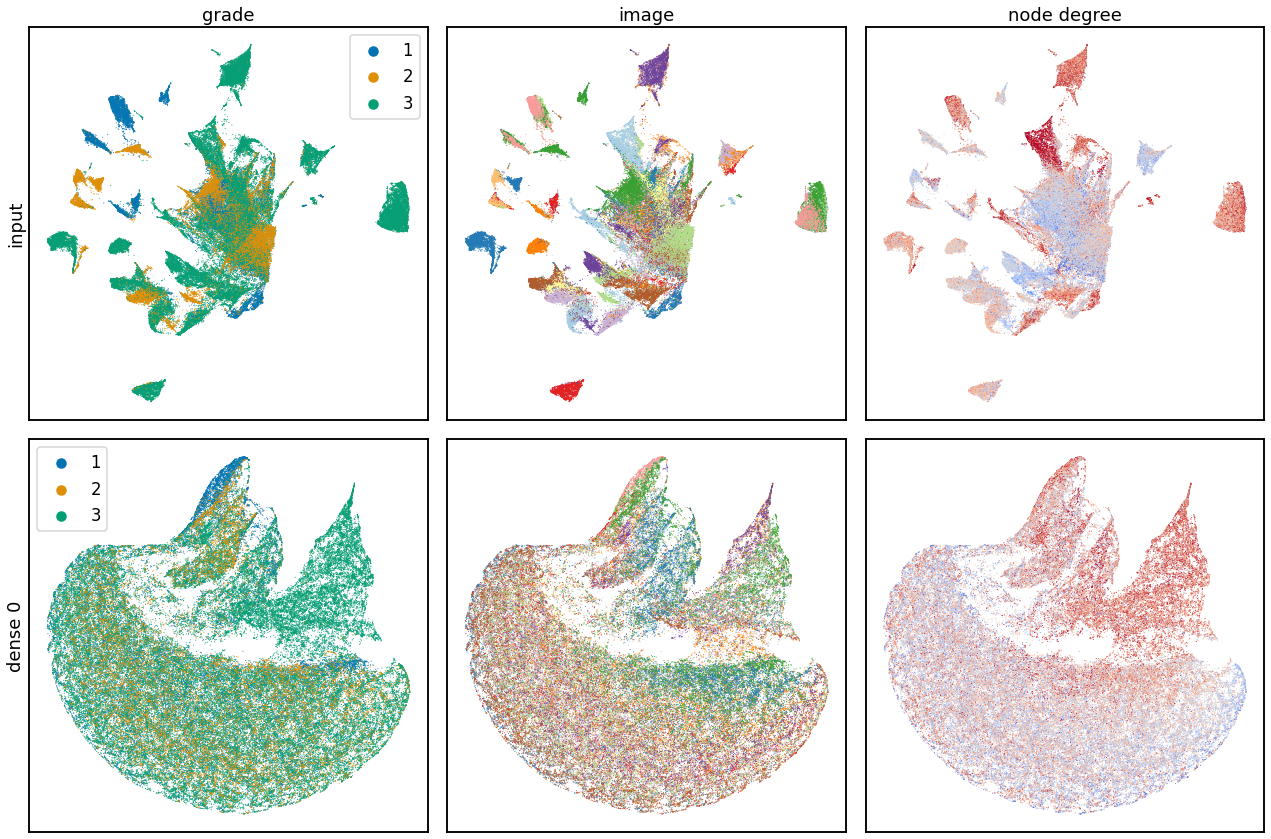

In [51]:
interpreter_mi.plot_umap_nodes(
    interpreter_mi.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_dense_feature_embedding0',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='bz',
    save=dir_figures+"supp_mi_std_node_emb_refactored", 
)

In [45]:
layer_name = 'Layer_dense_feature_embedding0'
acts = interpreter_mi._get_node_embeddings(
        idx=interpreter_mi.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter_mi.h[id].shape[0] for id in interpreter_mi.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.3504504423099513
Variance explained - images : 0.2288964490326194
R2 score - images: 0.14641780843178576
R2 score linreg - images: 0.32911330752469825


In [46]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.8189061544820725
/tmp/lisi_jyqwbqnf/input.mtx /tmp/lisi_jyqwbqnf/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.07187149128166487


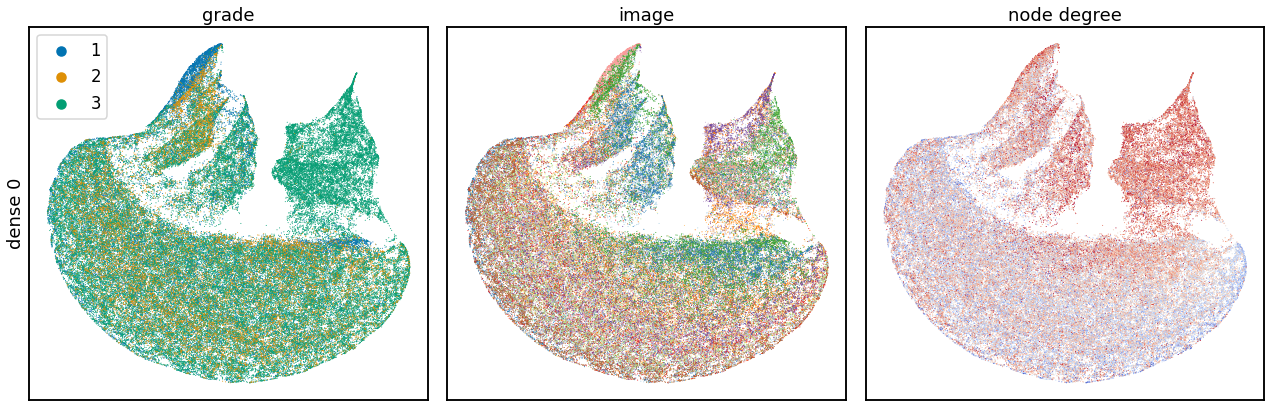

In [47]:
n_neighbors=50
layer_name = 'Layer_dense_feature_embedding0'
umap_emb, hue = interpreter_mi.plot_umap_nodes(
    interpreter_mi.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='bz',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [48]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [49]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.11245244829175288
Grade training score: 0.6201194553126892
Variance explained - images : -0.053453566661799456
R2 score - images: -0.1512382343150347
R2 score linreg - images: 0.10480854176666832


In [52]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_dense_feature_embedding0 layer - grade = 0.9914046664849225
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.3180270368964788
/tmp/lisi_j0a_wi12/input.mtx /tmp/lisi_j0a_wi12/
ilisi graph metric Layer_dense_feature_embedding0 layer - grade = 0.5071218142592251
/tmp/lisi_lslxjtjc/input.mtx /tmp/lisi_lslxjtjc/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.10675913265569502


#### Plot integration metrics

In [81]:
df_metrics

model   cv  prediction_score  variance_explained  r2_score  \
0   input  cv0          0.811474            0.865533  0.865352   
1   GCNSS  cv0          0.451527            0.351590  0.277498   
2   input  cv1          0.811474            0.865533  0.865352   
3   GCNSS  cv1          0.481571            0.486833  0.465756   
4   input  cv2          0.811474            0.865533  0.865352   
5   GCNSS  cv2          0.456966            0.408841  0.362929   
6     GCN  cv0          0.984178            0.988158  0.988158   
7     GCN  cv1          0.988470            0.993797  0.993797   
8     GCN  cv2          0.984865            0.991896  0.991896   
9      MI  cv0          0.350450            0.228896  0.146418   
10     MI  cv1          0.350450            0.228896  0.146418   
11     MI  cv2          0.350450            0.228896  0.146418   

    graph_connectivity     ilisi  1 - graph_connectivity  
0             0.968703  0.027638                0.031297  
1             0.885277  0.041435                0.114723  
2             0.968703  0.027638                0.031297  
3             0.795392  0.061423                0.204608  
4             0.968703  0.027638                0.031297  
5             0.874083  0.039615                0.125917  
6             0.981255  0.002017                0.018745  
7             0.988182  0.000252                0.011818  
8             0.982121  0.001055                0.017879  
9             0.818906  0.071871                0.181094  
10            0.818906  0.071871                0.181094  
11            0.818906  0.071871                0.181094

In [82]:
df_metrics_mean = pd.DataFrame(columns=["prediction_score", "variance_explained", "r2_score", "graph_connectivity", "ilisi", "1 - graph_connectivity"])
for model in ["input", "GCNSS", "GCN", "MI"]:
    df_metrics_mean.loc[model] = df_metrics[df_metrics["model"] == model].mean().values
df_metrics_mean.to_csv(dir_figures + "df_metrics_mean.csv")

In [79]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize=10)

<Figure size 720x720 with 0 Axes>

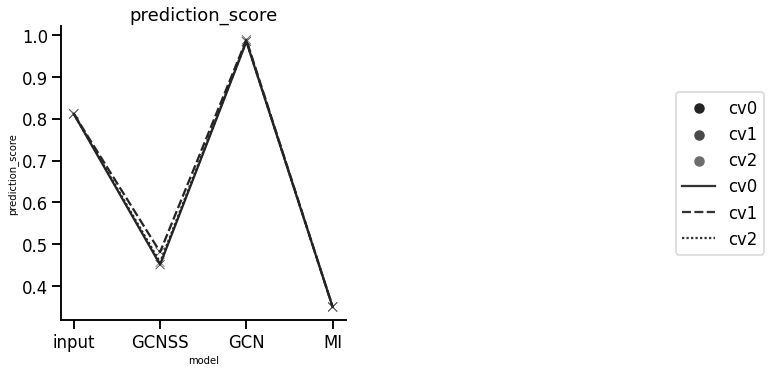

<Figure size 720x720 with 0 Axes>

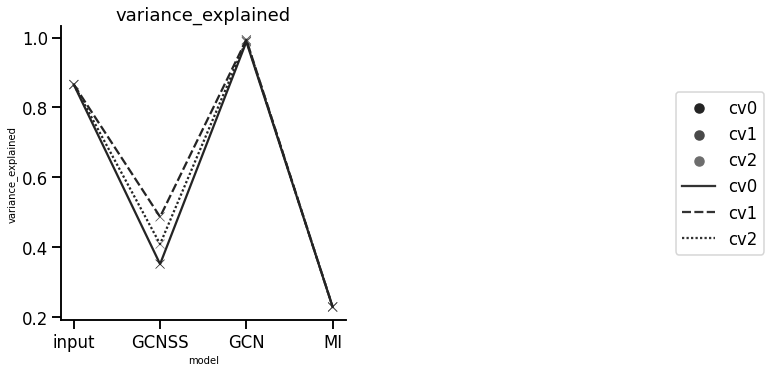

<Figure size 720x720 with 0 Axes>

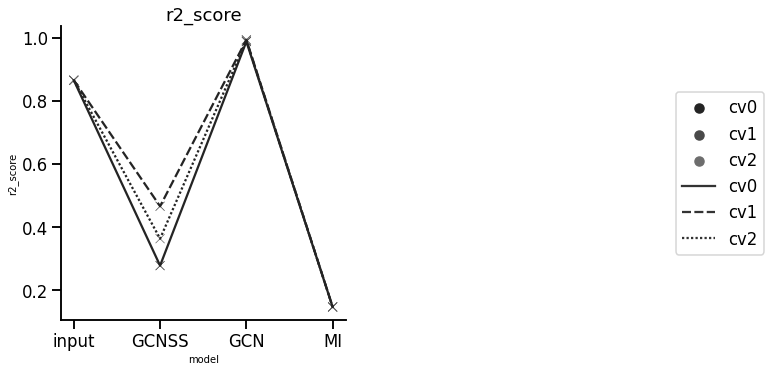

<Figure size 720x720 with 0 Axes>

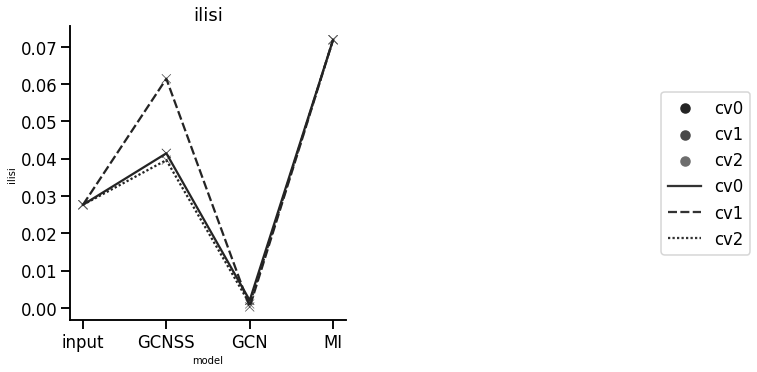

<Figure size 720x720 with 0 Axes>

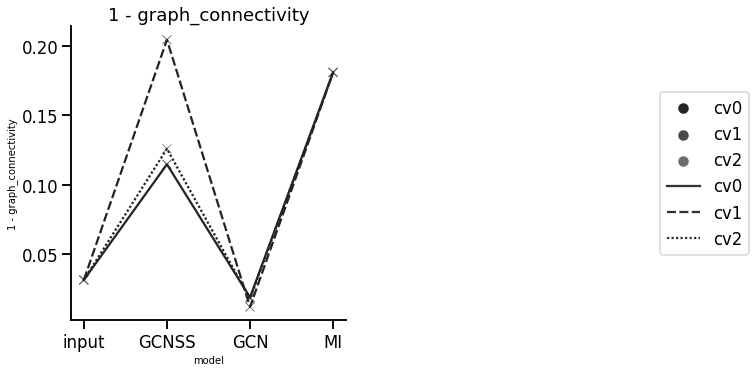

In [80]:
sns.set_palette('gray')

for i, metric in enumerate(["prediction_score","variance_explained","r2_score","ilisi","1 - graph_connectivity"]):
    plt.figure(figsize=(10,10))
    g = sns.FacetGrid(df_metrics, size=5)
    g.map(sns.scatterplot, "model", metric, hue=df_metrics["cv"], marker='x')
    g.map(sns.lineplot, "model", metric, style=df_metrics["cv"], linestyle='--')
    plt.legend(bbox_to_anchor=[2.5, 0.5], loc="right")
    plt.title(metric)
    plt.tight_layout()
    plt.savefig(dir_figures + f"{metric}_cvs.pdf", bbox_inches = "tight")

    plt.show()
